
# Libraries

In [53]:
import tqdm as tqdm
from torchvision import datasets
from sklearn.metrics import classification_report
%matplotlib inline

import os
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt


# Creating dataset

In [30]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[class_name]) for class_name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image transformations

In [31]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare DataLoader

In [32]:
train_dirs = {
    'normal': 'COVID-19_Radiography_Dataset/normal',
    'viral': 'COVID-19_Radiography_Dataset/viral',
    'covid': 'COVID-19_Radiography_Dataset/covid'
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 10092 normal examples
Found 1245 viral examples
Found 3516 covid examples


In [33]:
test_dirs = {
    'normal': 'COVID-19_Radiography_Dataset/test/normal',
    'viral': 'COVID-19_Radiography_Dataset/test/viral',
    'covid': 'COVID-19_Radiography_Dataset/test/covid'
}

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 100 normal examples
Found 100 viral examples
Found 100 covid examples


In [34]:
batch_size = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 2476
Number of test batches 50


# Data visualization

In [35]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

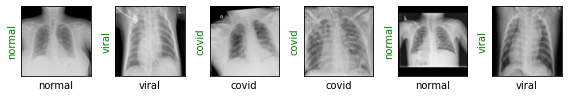

In [36]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

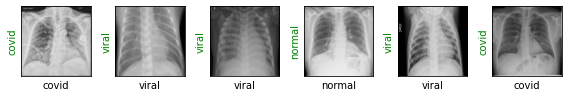

In [37]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Creating the model

In [38]:
resnet18 = torchvision.models.resnet18(pretrained=True)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [39]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [40]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

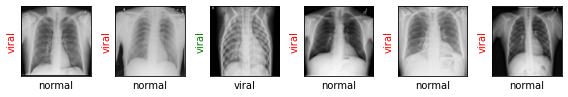

In [41]:
show_preds()

# Training the model

In [71]:
def train(epochs):
    print('Starting training..')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase
                pred_list = []
                true_list = []
                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())
                    pred_list += list(preds.numpy())
                    true_list += list(labels.numpy())


                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(pred_list, true_list)
                print(classification_report(pred_list, true_list))
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

Starting training..
Starting epoch 1/3
Evaluating at step 0
[2, 1, 2, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 0, 0, 1, 2, 1, 2, 0, 2, 2, 1, 1, 2, 0, 0, 2, 2, 1, 0, 2, 0, 2, 1, 1, 2, 0, 0, 2, 0, 2, 2, 0, 1, 1, 1, 2, 1, 2, 0, 2, 1, 2, 1, 1, 1, 1, 0, 0, 0, 2, 1, 0, 1, 2, 0, 0, 1, 2, 2, 1, 2, 2, 0, 0, 1, 2, 2, 0, 2, 1, 0, 0, 1, 2, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 0, 2, 2, 2, 2, 1, 2, 1, 0, 1, 1, 1, 1, 1, 2, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 0, 0, 1, 0, 2, 2, 2, 1, 0, 2, 2, 0, 2, 0, 2, 2, 0, 2, 1, 1, 1, 2, 0, 2, 2, 0, 2, 1, 2, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 2, 1, 1, 0, 2, 2, 1, 1, 0, 0, 2, 2, 0, 2, 2, 1, 2, 1, 0, 1, 2, 0, 0, 0, 0, 2, 2, 1, 2, 2, 1, 0, 1, 0, 1, 2, 0, 2, 2, 0, 1, 2, 1, 0, 0, 0, 2, 0, 1, 2, 1, 2, 1, 2, 1, 0, 1, 2, 2, 0, 0, 0, 1, 1, 2, 2, 2, 0, 0, 2, 0, 0, 1, 2, 2, 1, 0, 2, 2, 2, 0, 0, 2, 0, 1, 0, 1, 2, 1, 0, 0, 2, 2, 2, 2, 0, 1, 1, 2, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 2, 1, 1, 2, 1, 2, 1, 0, 2, 1, 2, 2, 0, 1, 0, 2, 1, 1, 0, 1, 0, 1, 0, 0, 2, 2, 0, 0] [2, 1, 2, 2, 2, 0, 2, 0, 2, 2, 0, 0, 2,

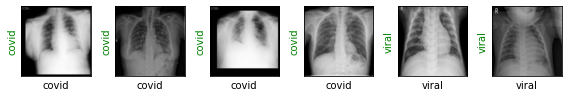

Evaluating at step 20
[2, 2, 0, 2, 1, 0, 1, 1, 2, 1, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 1, 1, 0, 0, 1, 2, 1, 2, 1, 1, 1, 2, 0, 0, 2, 2, 2, 2, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 2, 1, 1, 2, 0, 2, 2, 0, 1, 0, 0, 2, 2, 1, 0, 1, 0, 0, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 2, 0, 0, 2, 1, 2, 0, 0, 0, 0, 2, 2, 0, 2, 0, 1, 0, 2, 2, 1, 0, 1, 1, 0, 1, 0, 0, 0, 2, 2, 2, 1, 2, 0, 2, 2, 0, 2, 0, 0, 1, 2, 0, 0, 1, 2, 1, 2, 0, 1, 0, 0, 1, 0, 1, 1, 0, 2, 1, 1, 2, 1, 0, 1, 0, 2, 2, 1, 0, 1, 0, 1, 2, 0, 0, 1, 2, 0, 2, 0, 0, 1, 2, 2, 0, 1, 2, 0, 1, 0, 1, 0, 0, 2, 1, 2, 2, 0, 0, 2, 2, 0, 1, 2, 0, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1, 0, 2, 2, 1, 1, 0, 2, 0, 2, 1, 1, 0, 0, 2, 1, 0, 0, 0, 0, 2, 1, 2, 1, 2, 2, 2, 0, 1, 0, 2, 1, 0, 1, 2, 0, 0, 2, 1, 2, 2, 1, 2, 0, 1, 2, 0, 1, 1, 2, 1, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 0, 2, 2, 2, 2, 0, 0, 0, 1, 0, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, 2, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1] [2, 2, 0, 2, 1, 0, 1, 1, 2, 1, 1, 0, 0, 1, 0, 0, 0, 2, 0, 0, 2, 1, 0, 0, 1, 1

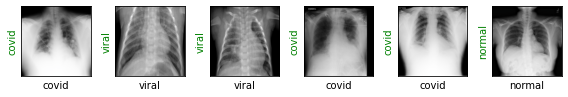

Evaluating at step 40
[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 2, 0, 2, 2, 2, 1, 1, 0, 0, 2, 0, 2, 0, 0, 0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 2, 1, 0, 2, 0, 2, 2, 0, 1, 1, 1, 2, 2, 1, 1, 1, 2, 0, 0, 0, 1, 1, 2, 0, 1, 1, 1, 1, 1, 1, 2, 0, 0, 1, 0, 2, 2, 1, 1, 2, 1, 0, 1, 0, 1, 0, 0, 2, 0, 1, 2, 1, 2, 1, 1, 1, 0, 1, 0, 2, 0, 2, 0, 0, 1, 0, 2, 2, 2, 0, 2, 1, 0, 2, 1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 1, 1, 0, 2, 2, 1, 1, 0, 0, 2, 1, 2, 0, 0, 2, 0, 0, 1, 0, 0, 1, 1, 0, 1, 2, 2, 1, 0, 1, 2, 0, 2, 2, 2, 1, 0, 2, 1, 1, 0, 0, 0, 2, 1, 2, 0, 1, 2, 1, 0, 2, 1, 0, 2, 1, 0, 1, 0, 2, 0, 2, 1, 2, 1, 0, 1, 2, 0, 0, 2, 1, 0, 1, 2, 2, 0, 1, 2, 1, 1, 1, 2, 0, 2, 2, 1, 2, 0, 0, 1, 2, 0, 0, 1, 1, 1, 1, 0, 1, 1, 2, 0, 2, 0, 2, 2, 1, 0, 1, 2, 1, 0, 2, 2, 2, 1, 0, 0, 0, 1, 0, 2, 1, 1, 1, 1, 0, 0, 1, 0, 2, 2, 2, 1, 1, 1, 1, 0, 2, 1, 2, 2, 1, 1, 1, 0, 2, 2, 1, 1, 0, 2, 2, 0, 0, 1, 2, 2, 0, 0, 1, 0, 2, 2, 1, 2, 0, 0, 2, 1, 1] [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 2, 0, 0, 0, 2, 0, 2, 2, 2, 1, 1, 0, 0, 2, 0

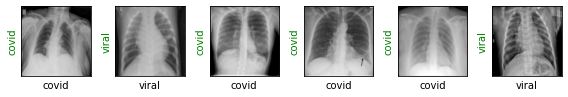

Performance condition satisfied, stopping..
CPU times: user 2min 38s, sys: 1.63 s, total: 2min 40s
Wall time: 1min 24s


In [72]:
%%time

train(epochs=3)

# Results

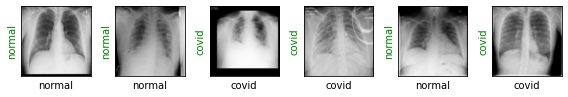

In [44]:
show_preds()


In [ ]:
traced_model = torch.jit.script(resnet18, images)
torch.jit.save(traced_model, "modelV1.pt")
